## Installs

In [30]:
# conda install -c conda-forge huggingface_hub

In [31]:
# pip install pytesseract

In [32]:
# pip install Pillow

In [33]:
# pip install easyocr

In [34]:
# pip install langchain

In [35]:
# pip install -U sentence-transformers

In [36]:
# pip install tf-keras

In [37]:
# pip install pinecone-client

In [38]:
# pip install dlai-tools

In [39]:
# pip install datasets

## Import

In [40]:

import functions as func

doEasyOCR = True
bigDataset = False


# Read dataset

In [41]:
# Read the dataset on pandas and join train and test
df = func.readDataSet(bigDataset)
print(f"Shape of the dataframe: {df.shape}")
df.head()

Shape of the dataframe: (15, 5)


,id,image,bboxes,ner_tags,tokens
0,doc7,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[53, 19, 175, 38], [600, 139, 745, 153], [188...","[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, ...","[PORTNET, cw9 olox %yg5, FACTURE, Facturation ..."
1,doc2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[99, 34, 286, 81], [642, 63, 802, 74], [514, ...","[3, 0, 0, 0, 13, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0,...","[KiTEA, Service Client:0802008002, FACTURE, KI..."
2,doc2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[99, 34, 286, 81], [642, 63, 802, 74], [514, ...","[3, 0, 0, 0, 13, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0,...","[KiTEA, Service Client:0802008002, FACTURE, KI..."
3,doc2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[50, 16, 216, 49], [790, 29, 952, 45], [47, 5...","[3, 0, 0, 13, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4,...","[AEON, Un Univers D'Expression, Aeon 360, Bd, ..."
4,doc5,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[399, 171, 544, 182], [748, 211, 887, 225], [...","[3, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, ...","[Auto-entrepreneur, Date : 28/03/2023, Facture..."


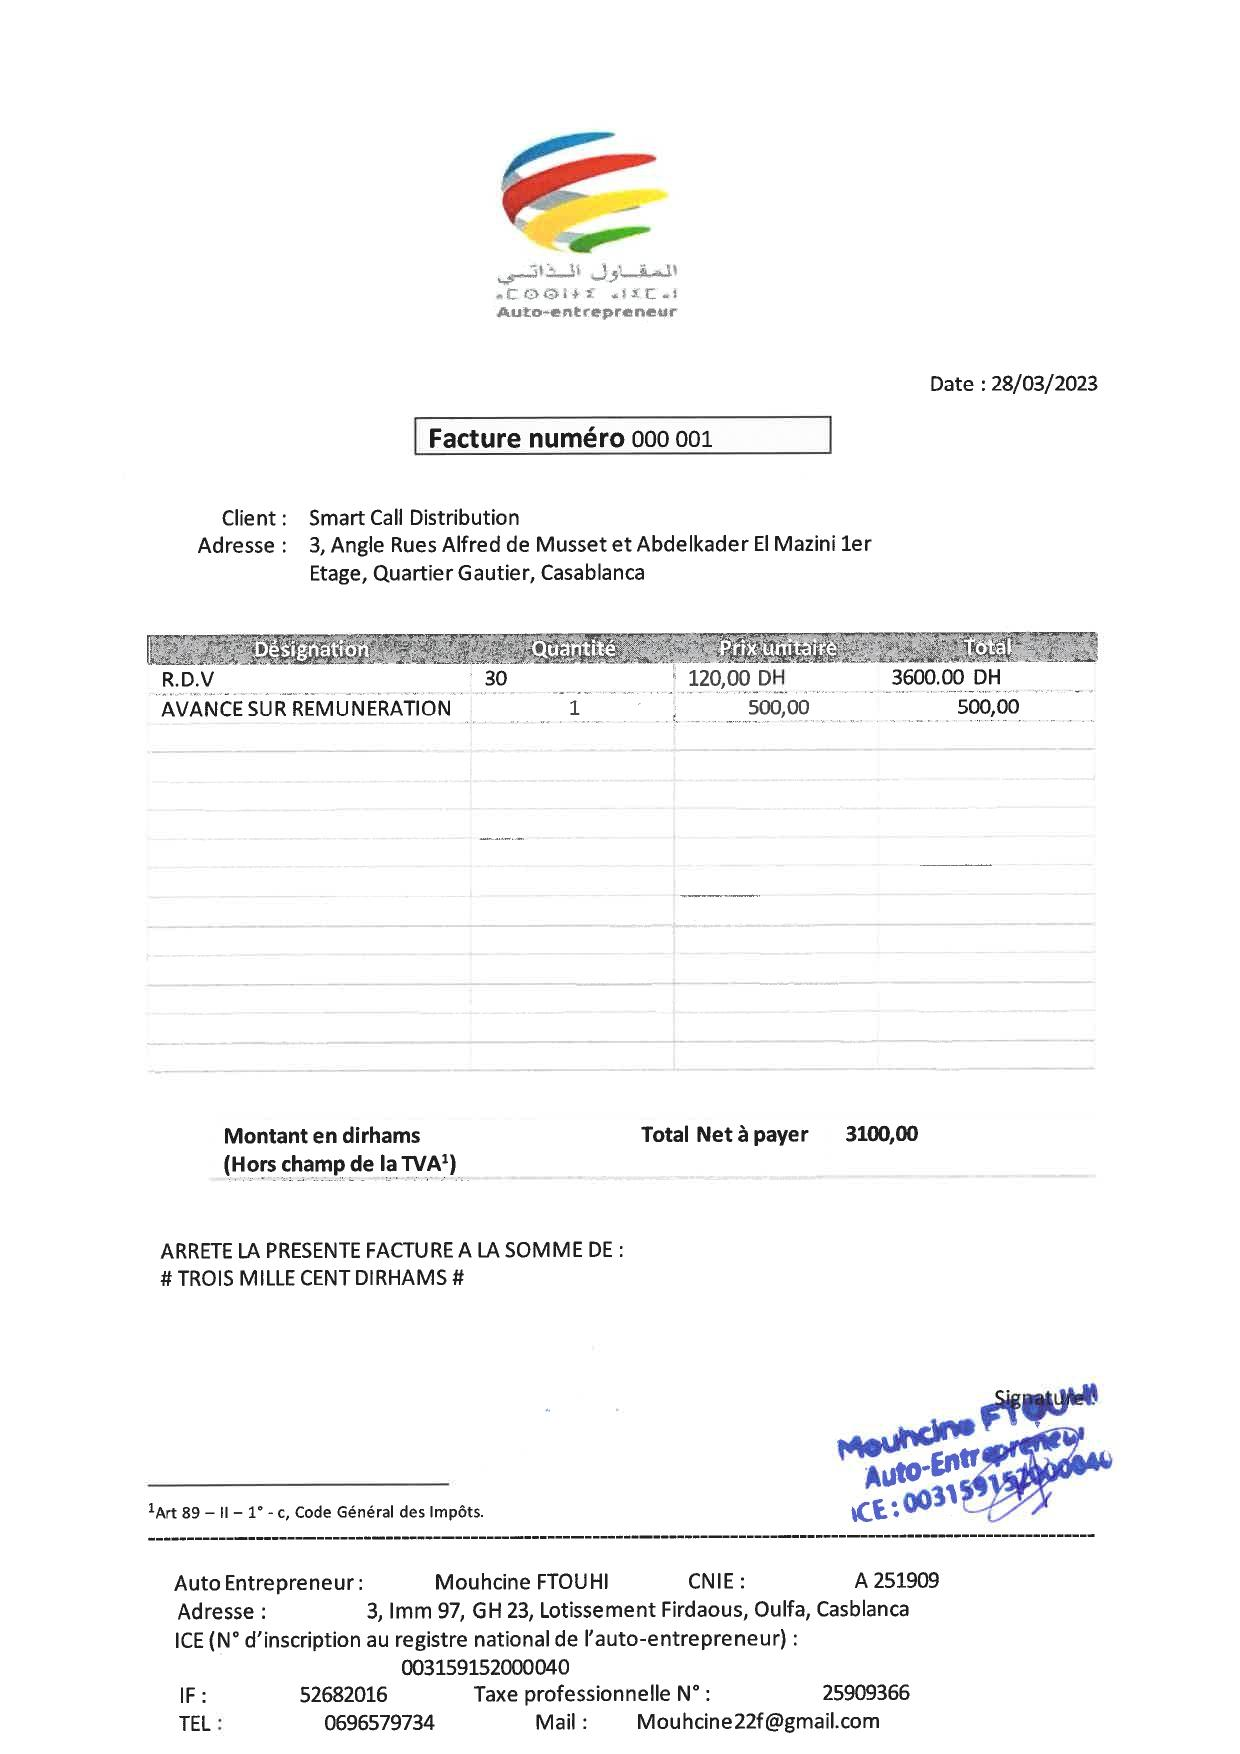

In [42]:
l_images = []
l_images_bytes = []

for ima in df["image"]:
    l_images_bytes.append(ima["bytes"])

    l_images.append(func.imageObjCreation(ima["bytes"])) 

# small_image = image.resize((200, 300))

# Display the image
l_images[0].show()

# OCR read images

In [43]:
l_textOcr = []

for image_i in range(len(l_images)):
    l_textOcr.append(func.readImgOCR(l_images_bytes[image_i], l_images[image_i], doEasyOCR))

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
~i2i J;_il ~5001+ { ~c ! Auro-enrepraneur Date 28/03/2023 Facture numéro 000 001 Client Smart Call Distribution Adresse 3, Angle Rues Alfred de Musset et Abdelkader El Mazini ler Etage, Quartier Gautier, Casablanca Dësignátíön 'Quantité Prixunitaïre Total RD.V 30 120,00 DH 3600.00 DH AVANCE SUR REMUNERATION 500,00 500,00 Montant en dirhams Total Net à payer 3100,00 (Hors champ de la TVA') ARRETE LA PRESENTE FACTURE A LA SOMME DE #TROIS MILLE CENT DIRHAMS # Fifltkeh 'Art 89 II = 1' c, Code Général des Impôts. KCE: Auto Entrepreneur Mouhcine FTOUHI CNIE A 251909 Adresse 3, Imm 97, GH 23, Lotissement Firdaous, Oulfa, Casblanca ICE (N' d'inscription au registre national de lauto-entrepreneur) 003159152000040 IF : 52682016 Taxe professionnelle N' 25909366 TEL 0696579734 Mail Mouhcine22f@gmail com Mouncho CPnnzl Auto-Entr Oocw S9yY 00315


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
KITEA Service Client :0802 00 8002 FACTURE KITEA CITY GALILEE 87, rue Taha Houcine CASABLANCA Maroc Page CARROT Adresse N' Facture FACTO1122873 ANFA CASABLANCA Maroc Votre ref  Date facture 20/02/2023 Imprime le 20/02/2023 à 14h.23 P : 0632719813 Commande client CMDO02995133 Vendeur : Salma FOUADI ICE : 000229955000088 Remise Réference Désionation Variante Qté PVP TTC Remise PU TTC Campagne IVA Montant HI Montant IIC 10035696 SET RICK TABLE CHENE/BL 1,00 2 195,00 829,17 20,00 829 17 2 195,00 110x70x75 CHAISES Total Remise 0,00 La présente facture est arrêtée à la somme de Total Hors taxes 829,17 MAD Deux Mille Cent Quatre-Vingt-Quinze Dirhams Total TVA 365,83 MAD Total TTC 2 195,00 MAD Droits de timbre 0 00 MAD Net à payer 2 195,00 MAD Payé par Mode de paiement Date de paiement Montant CARTE 20/02/2023 2 195,00 Supplier signature Customer signature KITEA SA Siège administratif Zone industriel Ouled Rahou centre Sidi Maarouf lot. medersa Lot N'1, Ain chock CP 204

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
KITEA Service Client :0802 00 8002 FACTURE KITEA CITY GALILEE 87, rue Taha Houcine CASABLANCA Maroc Page CARROT Adresse N' Facture FACTO1122873 ANFA CASABLANCA Maroc Votre ref  Date facture 20/02/2023 Imprime le 20/02/2023 à 14h.23 P : 0632719813 Commande client CMDO02995133 Vendeur : Salma FOUADI ICE : 000229955000088 Remise Réference Désionation Variante Qté PVP TTC Remise PU TTC Campagne IVA Montant HI Montant IIC 10035696 SET RICK TABLE CHENE/BL 1,00 2 195,00 829,17 20,00 829 17 2 195,00 110x70x75 CHAISES Total Remise 0,00 La présente facture est arrêtée à la somme de Total Hors taxes 829,17 MAD Deux Mille Cent Quatre-Vingt-Quinze Dirhams Total TVA 365,83 MAD Total TTC 2 195,00 MAD Droits de timbre 0 00 MAD Net à payer 2 195,00 MAD Payé par Mode de paiement Date de paiement Montant CARTE 20/02/2023 2 195,00 Supplier signature Customer signature KITEA SA Siège administratif Zone industriel Ouled Rahou centre Sidi Maarouf lot. medersa Lot N'1, Ain chock CP 204

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
A-QN Un Univers D'Expression Aeon 360 Bd, Bahmad, Rès Najmat Bahmad Entrée B, Etg. 5, Bur. 88 Casablanca Maroc KLEM ICE 000083797000006 Facture FI2023/0581 Date de facture: Source Référence: 09/10/2023 S0400 S0400 Description Quantité Prix unitaire Remise % ) Taxes Montant Préparation dun questionnaire Q/R MEN 1,000 10000,00 0,00 TVA 20% VENTES 10000,00 DH Total HT 10000,00 DH Taxes 2000,00 DH Total TTC 12000,00 DH Taxes Base de calcul Montant TVA 20% VENTES 10000,00 DH 2000,00 DH Note: Délais de paiement 30 jours à compter la date de signature du Bon de Commande Web: www.aeon.ma Patente: 32391343 IF: 15269782 RC: 331787 ICE: 000182620000061 Page


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
~i2i J;_il ~5001+ { ~c ! Auro-enrepraneur Date 28/03/2023 Facture numéro 000 001 Client Smart Call Distribution Adresse 3, Angle Rues Alfred de Musset et Abdelkader El Mazini ler Etage, Quartier Gautier, Casablanca Dësignátíön 'Quantité Prixunitaïre Total RD.V 30 120,00 DH 3600.00 DH AVANCE SUR REMUNERATION 500,00 500,00 Montant en dirhams Total Net à payer 3100,00 (Hors champ de la TVA') ARRETE LA PRESENTE FACTURE A LA SOMME DE #TROIS MILLE CENT DIRHAMS # Fifltkeh 'Art 89 II = 1' c, Code Général des Impôts. KCE: Auto Entrepreneur Mouhcine FTOUHI CNIE A 251909 Adresse 3, Imm 97, GH 23, Lotissement Firdaous, Oulfa, Casblanca ICE (N' d'inscription au registre national de lauto-entrepreneur) 003159152000040 IF : 52682016 Taxe professionnelle N' 25909366 TEL 0696579734 Mail Mouhcine22f@gmail com Mouncho CPnnzl Auto-Entr Oocw S9yY 00315


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
Genious Communications SARL Villa 290. Assif B. genious Code postal: 40 000 Marrakech Maroc Beyondperceptions' Adressé à Aeon 360 (ICE 000182620000061) Bd Ibn Tachfine, Ouled Ziane Rés. Azahra, 1 Etage; Apt 31 Casablanca, Maroc, 22000 Morocco Facture proforma # #328770 NON PAYÉE Date de facturation: 17/10/2023 3066.00 Dhs Description Total Intel i5-4430 Quad Core 3.2 Ghz server.aeon.ma (01/11/2023 30/11/2023) 2555.00 Dhs Memory: 16 GB (2x8GB) Disk 1: ITB HD Disk 2: None Disk 3: None Disk 4: None RAID Controller: None Uplink: 100 Mbitsls Tier 1 Bandwidth: 10 TB (included) Operating System: AlmaLinux 8.4 x64 Control panel: cPanel (max. 100 accounts) Support: Managed RlSoft Backup: None FTPISSH Backup: None Litespeed: None Sous-total 2555.00 Dhs 20.009 Morocco 511.00 Dhs Total 3066.00 Dhs Genious Communications S.A.R.L. Capital 1 200 000 Dhs Patente 67095151 RC 28655 CN.S.S. 7547427 E-TOUB! 06521385 - ICE 000227325000094 RIB 022 780 000 235 00 280123 67 74 Site Int

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
Facuure 6)>ili orange SM ART CALL D ITRBUTDN Num éro de Facture F-0323-1926835 192 ETG 4 RES B N com pte client 10564756 BD ZERKTOUNI Date d 'éditin 26/03/2023 20000 CASABLANCA Vos coordonnées SM ART CALL DSTRBUTDN Votre facuure du 18 M ars 2023 192 ETG 4 RES B BD ZERKTOUNI M ontanttotalà payer 396 , DH Dom iiliatin bancaie Date li ie de paim ente 09/04/2023 PIssu Jsl ,/ Tiuhie :SM ART CALL DITRBUTDN Banque :ATTIARI AFABANK N de Com pte Pourvotre sécurité en cette pérpde, nous vous 007780000629500000017864 recom m andons de payer vos factures en lggne . Votre CE 001685924000018 sécurité estnotre rité Nous contacter Résum é de h facuure M ontanten DH Parcourir 0 range M aroc Vos forfaits/abonnem ents etoptins 330,00 Lotisem enth colne I m m eubb bs Q uate Tem ps M ontanthT 330,00 Votre servie clients TVA (20%) ^.G.ci 66,00 178 depui un m obi 0 range (appelgratui) (+212)05 20 178 178 TotalTTC 396 ,00 +coûtappelsebn opérateur 7 j7 de 07h à OOh Sole en votre faveur 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
DUPLICATA 94ai} Forfait Optimis Page 8/8 Societe OUTIDIS OUTIDIS 90 SIDI ABDERRAHMANE N Client 1.56762187970 20200 CASABLANCA HAY HASSANI N Facture 0000632339052023 Maroc N dAppel 06 66 62 79 19 Date Facture 08/05/2023 Date début Date Fin Période facturée 01/04/2023 30/04/2023 FRAIS MENSUELS Frais de plafonnement 01/05/2023 31/05/2023 19.00 Forfait 25H 20G0 01/05/2023 31/05/2023 138.50 Internet Mobile Gratuit 01/05/2023 31/05/2023 0.00 Option intra flotte 0 dh 01/05/2023 31/05/2023 0.00 Frais de plafonnement 11/04/2023 30/04/2023 12.67 Forfait 25H 20G0 11/04/2023 30/04/2023 92.33 FRAIS PONCTUELS Frais de mise en service 157.50 TOTAL CONTRAT : 420.00 Payez vos factures en toute sécurité via les canaux suivants Guichets et applications bancaires Bornes Multiservices Application Mobile Service dassistance Via les guichets et applications Sur les bornes interactives Via MonEspaceMT . via WhatsApp bancaires de votre choix . en agence commerciale 001522585000066 ~la; 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
Facuure 6)>ili orange SM ART CALL D ITRBUTDN Num éro de Facture F-0423-1968363 192 ETG 4 RES B N com pte client 10564756 BD ZERKTOUNI Date d 'éditin 26/04/2023 20000 CASABLANCA Vos coordonnées SM ART CALL DSTRBUTDN Votre facuure du 18 Avril2023 192 ETG 4 RES B BD ZERKTOUNI M ontanttotalà payer 396 , DH Dom iiliatin bancaie Date li ie de pajm ente 09/05/2023 PIssu Jsl ,/ Tiuhie :SM ART CALL DITRBUTDN Banque :ATTIARI AFABANK N de Com pte Pourvotre sécurité en cette pérpde, nous vous 007780000629500000017864 recom m andons de payer vos factures en lggne . Votre CE 001685924000018 sécurité estnotre rité Nous contacter Résum é de h facuure M ontanten DH Parcourir 0 range M aroc Vos forfaits/abonnem ents etoptins 330,00 Lotisem enth colne I m m eubb bs Q uate Tem ps M ontanthT 330,00 Votre servie clients TVA (20%) ^.G.ci 66,00 178 depui un m obi 0 range (appelgratui) (+212)05 20 178 178 TotalTTC 396 ,00 +coûtappelsebn opérateur 7 j7 de 07h à OOh Sole en votre faveur 0

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
Azeddine KABBAJ Casablanca le 6 Février 2023 Avocat Agrée   près la Cour de Cassation Rue dAgadir Casablanca Tél. 022.26.05.52 022.27.12.17 Fax 022.47.13.02 E-mail nia itre_Kabbaj@menara.ma Réception sur rendez-vous SMARTCALL DISTRIBUTION Casablanca NIREF: 8570 SMARTCALLDISTRIBUTION C/ Amnine Soussi Sadouk V Ref: NOTED'HONORAIRES Honoraires so0o,00 DH TVA (10%) S00,00 DH TOTAL 5500,00 DH Eel: Patente n" 34205024 IF 41810908 CNSS 2582486 ICE 001634351000054 Azoshne Kabb} Avocar 1Ruelco 8428adisSass Cassblanca 27,12


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
Genious Communications SARL Villa 290. Assif B. genious Code postal: 40 000 Marrakech Maroc Beyondperceptions' Adressé à Aeon 360 (ICE 000182620000061) Bd Ibn Tachfine, Ouled Ziane Rés. Azahra, 1 Etage; Apt 31 Casablanca, Maroc, 22000 Morocco Facture proforma # #328770 NON PAYÉE Date de facturation: 17/10/2023 3066.00 Dhs Description Total Intel i5-4430 Quad Core 3.2 Ghz server.aeon.ma (01/11/2023 30/11/2023) 2555.00 Dhs Memory: 16 GB (2x8GB) Disk 1: ITB HD Disk 2: None Disk 3: None Disk 4: None RAID Controller: None Uplink: 100 Mbitsls Tier 1 Bandwidth: 10 TB (included) Operating System: AlmaLinux 8.4 x64 Control panel: cPanel (max. 100 accounts) Support: Managed RlSoft Backup: None FTPISSH Backup: None Litespeed: None Sous-total 2555.00 Dhs 20.009 Morocco 511.00 Dhs Total 3066.00 Dhs Genious Communications S.A.R.L. Capital 1 200 000 Dhs Patente 67095151 RC 28655 CN.S.S. 7547427 E-TOUB! 06521385 - ICE 000227325000094 RIB 022 780 000 235 00 280123 67 74 Site Int

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
PGRTNET in Statcnne öJ9jL Cjj9! cl1> bj9g FACTURE Facturation des services PORTNET SA. ògiLjJl 6) JlueVl ëJl Code Client: 952238 N FACTURE Date d'émission Nom Client: OUTIDIS 00197427 05/07/2022 Adresse Client: 10.RUE LIBERTE ETAGE 3.APPARTEMENT 5.CASABLANCA blsuJl ps) ICE Client: 003052404000075 Numéro de souscription 52022100078486 Période facturée 6 s9ÈJJl aljJl Type Client: IMPORTATEURS De 05/07/2022 A 31/12/2022 CMboyl olsJl €3i ö v>91 Code Nature des prestations Quantité Unité Tarif Montant [Forfait 2 Importateur 10 opérations 1.000 Unit(s) 2650.00 2650.00 [Description: Forfait 2 10 opérations y compris frais d'accès annuel. [Forfait valable jusqu'au 31 Décembre de l'année en cours- li u9" EaaajJl 2650.00 TOTAL H.T Tax Base Amount äolajl äqäJl _lc äuiaJl 530.00 TVA 20% VENTES 2650.00 530.00 TAXES cliaJl €aazJJl 3180.00 MONTANT A PAYER Facture arrêtée à la somme de trois mille cent quatre-vingts dirham et zéro centime TTC Détail de la Facturation: Type de f

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
Facuure 6)>ili orange SM ART CALL D ITRBUTDN Num éro de Facture F-0123-1879887 192 ETG 4 RES B N com pte client 10564756 BD ZERKTOUNI Date d 'éditin 23/01/2023 20000 CASABLANCA Vos coordonnées SM ART CALL DSTRBUTDN Votre facuure du 18 Janvir 2023 192 ETG 4 RES B BD ZERKTOUNI M ontant totalà payer 396 , DH Dom iiliatin bancaie Date li ie de paim ente 08/02/2023 PIssu Jsl ,/ Tiuhie :SM ART CALL DITRBUTDN Banque :ATTIARI AFABANK N de Com pte Pourvotre sécurité en cette pérpde, nous vous 007780000629500000017864 recom m andons de payer vos factures en lggne . Votre CE 001685924000018 sécurité estnotre rité Nous contacter Résum é de h facuure M ontanten DH Parcourir 0 range M aroc Vos forfaits/abonnem ents etoptins 330,00 Lotisem enth colne I m m eubb bs Q uate Tem ps M ontanthT 330,00 Votre servie clients TVA (20%) ^.G.ci 66,00 178 depui un m obi 0 range (appelgratui) (+212)05 20 178 178 TotalTTC 396 ,00 +coûtappelsebn opérateur 7 j7 de 07h à OOh Sole en votre faveu

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto extraído con OCR:
CUISTOQUIP E Q U | P E M EnT s C H R lAlle Des Cuistois Equipements et services pour: collectivités; hôtels, restaurants; cafés; glaciers; pâtisseries; boulangeries; traiteurs Facture SORA Numéro Date Page 81 RUE 5 KHALIL LAVILLETTE CASABLANCA CASABLANCA FA2022-000246 29/12/2022 00.00.00 1/1 ICE: 000189068000080 Num DESIGNATION QTE UNITE PRIX UNI TTC MONTANT TTC Bon de Livraison N?BL2022-000382 du 29/12/2022 RECHAUD AVEC 4 BRÛLEURS A GAZ POSABLE 2OKW TURHAN - 10 000,00 10 000,00 TURKIE DIM 600X630X300 CUISEUR A PATE POSABLE ELECTRIQUE 8 Lt 6 KW 380V- TURHAN 000,00 000,00 TURKIE DIM 400X630X300 BAIN MARIE ELECTRIQUE POSABLE 2.5 KW 220V TURHAN U 5 500,00 5 500,00 TURKIE DIM 400X630X300 FRITEUSE SIMPLE ELECTRIQUE AVIDANGE 12L 230V MFI2OR U 5 500,00 5 500,00 ROLLER GRILL FRANCE DIM 350X470X350 MM CUSTOQUIP Ra(uccommercial Diyfan Ruc Abocikatin Iel 8552417994 Diovs Sasabian; 22 33 1: {mail: (uisraaueqmall <om TOTAL HT REMISE TVA TOTAL TTC ACOMPTE NET A PAYER 24 166,6

# LLM

In [44]:
parser = func.pydanticParser()

print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"description": "Facture Datamodel", "properties": {"date": {"default": null, "description": "Date of the facture", "title": "Date", "type": "string"}, "monto": {"default": null, "description": "Total money amount of the facture", "title": "Monto", "type": "string"}, "facture_number": {"default": null, "description": "Identifier of the facture", "title": "Facture Number", "type": "string"}}}
```


In [45]:
l_facture_data = []
l_generated_text = []
for textOcr in l_textOcr:
    system_instructions, prompt = func.instructionsFormat(parser, textOcr)
    generated_text = func.LLMModelCall(system_instructions, prompt)
    l_generated_text.append(generated_text)
    # Parsear la respuesta generada usando PydanticOutputParser
    facture_data = parser.parse(generated_text)
    l_facture_data.append(facture_data)
    print(facture_data)


date='28/03/2023' monto='3100,00 DH' facture_number='000001'
date='20/02/2023' monto='2 195,00 MAD' facture_number='FACTO1122873'
date='20/02/2023' monto='2 195,00 MAD' facture_number='FACTO1122873'
date='09/10/2023' monto='12000,00 DH' facture_number='FI2023/0581'
date='28/03/2023' monto='3100,00 DH' facture_number='000001'
date='17/10/2023' monto='3066.00 Dhs' facture_number='#328770'
date='26/03/2023' monto='396 , DH' facture_number='F-0323-1926835'
date='08/05/2023' monto='420.00' facture_number='0000632339052023'
date='26/04/2023' monto='396 , DH' facture_number='F-0423-1968363'
date='6 Février 2023' monto='5500,00 DH' facture_number='8570'
date='17/10/2023' monto='3066.00 Dhs' facture_number='#328770'
date='05/07/2022' monto='3180.00' facture_number='52022100078486'
date='23/01/2023' monto='396 , DH' facture_number='F-0123-1879887'
date='29/12/2022' monto='29 000,00' facture_number='FA2022-000246'
date='22/03/2023' monto='7 796.40' facture_number='FV230054'


# Vectorial database

In [46]:
model = func.embedingModelCreation()

Sorry no cuda.


In [47]:
index = func.dataBaseCreation(model)

quickstart


In [48]:
import json

func.insertDataBase(index, l_generated_text, model)

  0%|          | 0/15 [00:00<?, ?it/s]

In [55]:
query = "'monto': '420'"
func.runQuery(query, index, model)

0.29: {'date': '08/05/2023', 'facture_number': '0000632339052023', 'monto': '420.00'}
0.27: {'date': '17/10/2023', 'facture_number': '#328770', 'monto': '3066.00 Dhs'}
0.27: {'date': '17/10/2023', 'facture_number': '#328770', 'monto': '3066.00 Dhs'}
0.27: {'date': '20/02/2023', 'facture_number': 'FACTO1122873', 'monto': '2 195,00 MAD'}
0.27: {'date': '20/02/2023', 'facture_number': 'FACTO1122873', 'monto': '2 195,00 MAD'}
0.27: {'date': '26/03/2023', 'facture_number': 'F-0323-1926835', 'monto': '396 , DH'}
0.26: {'date': '22/03/2023', 'facture_number': 'FV230054', 'monto': '7 796.40'}
0.26: {'date': '6 Février 2023', 'facture_number': '8570', 'monto': '5500,00 DH'}
0.26: {'date': '26/04/2023', 'facture_number': 'F-0423-1968363', 'monto': '396 , DH'}
0.25: {'date': '05/07/2022', 'facture_number': '52022100078486', 'monto': '3180.00'}
